In [14]:
import piezo
import pandas as pd
from catomatic.CatalogueBuilder import BuildCatalogue

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook demonstrates how to use catomatic, and its various functionalities - a number of non-trivial decisions need to be made depending on the data and context, which are covered here.

# Import mutations and samples tables

In [15]:
mutations = pd.read_csv('../data/mutations.csv', index_col=0)
mutations

,UNIQUEID,MUTATION,FRS
0,1,gene@A1S,0.73
1,2,gene@A1S,0.25
2,4,gene@A2S,0.40
3,7,gene@A3S,0.98
4,8,gene@A3S,0.90
5,9,gene@A3S,0.86


In [16]:
samples = pd.read_csv('../data/samples.csv', index_col=0)
samples

,UNIQUEID,PHENOTYPE
0,1,R
1,2,S
2,3,R
3,4,S
4,5,R
5,6,S
6,7,S
7,8,S
8,9,R
9,10,R


# Build the catalogue

In [17]:
catalogue = BuildCatalogue(samples=samples, mutations=mutations)

Can return as a dictionary, where each key is a mutations:

In [18]:
catalogue.return_catalogue()

{'gene@A2S': {'pred': 'S',
  'evid': {'proportion': 0.0,
   'confidence': (np.float64(0.0), np.float64(0.7934506856227626)),
   'contingency': [[0, 1], [3, 1]]}},
 'gene@A1S': {'pred': 'U',
  'evid': {'proportion': 0.5,
   'confidence': (np.float64(0.09453120573423071),
    np.float64(0.9054687942657693)),
   'contingency': [[1, 1], [3, 2]]}},
 'gene@A3S': {'pred': 'U',
  'evid': {'proportion': 0.3333333333333333,
   'confidence': (np.float64(0.061491944720396215),
    np.float64(0.7923403991979523)),
   'contingency': [[1, 2], [3, 2]]}}}

Or can return as a piezo-structure dataframe:

In [19]:
#note, wildcards can be supplied as a dictionary or path to json. for_piezo will add placeholder rows to avoid an issue with piezo (requires R+U+S)
catalogue.build_piezo(genbank_ref='demo_gene', catalogue_name='demo', version='0.1.1', drug='eg', wildcards='../data/demo_wildcards.json', for_piezo=False)

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@A2S,S,NaN,"{'proportion': 0.0, 'confidence': (0.0, 0.7934...",NaN
3,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@*=,S,NaN,{'default_rule': 'True'},NaN
1,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@A1S,U,NaN,"{'proportion': 0.5, 'confidence': (0.094531205...",NaN
2,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@A3S,U,NaN,"{'proportion': 0.3333333333333333, 'confidence...",NaN
4,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@-*_indel,U,NaN,{'default_rule': 'True'},NaN
5,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@*_indel,U,NaN,{'default_rule': 'True'},NaN
6,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@-*?,U,NaN,{'default_rule': 'True'},NaN
7,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@*?,U,NaN,{'default_rule': 'True'},NaN
8,demo_gene,demo,0.1.1,GARC1,RUS,eg,gene@del_0.0,U,NaN,{'default_rule': 'True'},NaN


Or can call 'to_piezo' to directly save as a csv:

In [20]:
catalogue.to_piezo(genbank_ref='demo_gene', catalogue_name='demo', version='0.1.1', drug='eg', wildcards='../data/demo_wildcards.json', outfile='./temp/demo_catalogue.csv')

Piezo can then be used to make predictions:

In [21]:
catalogue = piezo.ResistanceCatalogue("./temp/demo_catalogue.csv")
print ('prediction for mutation gene@A1S:', catalogue.predict('gene@A1S'))
print ('prediction for mutation gene@A2S:', catalogue.predict('gene@A2S'))


prediction for mutation gene@A1S: {'eg': 'U'}
prediction for mutation gene@A2S: {'eg': 'S'}


## Statistical Tests

The default parameter for test type is `None`, which instantiates a protocol whereby susceptible mutations are defined as those with homogenously susceptible phenotypes at the level at which it is being classified - this facilitates the unlocking mechanism, however beyond that, no phenotyping is done.

To classify resistant variants, one can run a traditional binomial test on the proportion of resistance observed at that level against a user-defined background rate, by specifying `Binomial` and a background.

In [22]:
#run a binomial test with a background rate of 20% and a 90% 2-tailed confidence level (p=0.9) - notice R classification.
catalogue = BuildCatalogue(samples=samples, mutations=mutations, test='Binomial', background=0.05, p=0.9)
catalogue.build_piezo(genbank_ref='demo_gene', catalogue_name='demo_binomial', version='0.1.1', drug='eg', wildcards='../data/demo_wildcards.json')

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@A2S,S,NaN,"{'proportion': 0.0, 'confidence': (0.0, 0.7301...",NaN
3,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@*=,S,NaN,{'default_rule': 'True'},NaN
1,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@A1S,R,NaN,"{'proportion': 0.5, 'confidence': (0.120866319...",NaN
2,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@A3S,U,NaN,"{'proportion': 0.3333333333333333, 'confidence...",NaN
4,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@-*_indel,U,NaN,{'default_rule': 'True'},NaN
5,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@*_indel,U,NaN,{'default_rule': 'True'},NaN
6,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@-*?,U,NaN,{'default_rule': 'True'},NaN
7,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@*?,U,NaN,{'default_rule': 'True'},NaN
8,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@del_0.0,U,NaN,{'default_rule': 'True'},NaN


One can also run a Fisher's test against a calculated background rate from a contintengcy table by specifying test type `Fisher`. 

Backgrounds are defined as R or S phenotypes in the absence of that mutation or any mutations not yet classified as susceptible (ie, background = 'WT' phenotypes + classified S phenotypes). Essentially, the background proportion of resistance is that which we cannot logically explain and probably arises from error or missing information.

In [23]:
#run a Fisher test at 10% 2-tailed confidence level (p=0.1) - notice the S classification in the second row (a crazy p-value, I realise - for demonstration). 
catalogue = BuildCatalogue(samples=samples, mutations=mutations, test='Fisher', p=0.1)
catalogue.build_piezo(genbank_ref='demo_gene', catalogue_name='demo_fisher', version='0.1.1', drug='eg', wildcards='../data/demo_wildcards.json')

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@A2S,S,NaN,"{'proportion': 0.0, 'confidence': (0.0, 0.0155...",NaN
1,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@A3S,S,NaN,"{'proportion': 0.3333333333333333, 'confidence...",NaN
3,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@*=,S,NaN,{'default_rule': 'True'},NaN
9,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,placeholder@R1R,R,NaN,{},NaN
2,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@A1S,U,NaN,"{'proportion': 0.5, 'confidence': (0.455746361...",NaN
4,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@-*_indel,U,NaN,{'default_rule': 'True'},NaN
5,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@*_indel,U,NaN,{'default_rule': 'True'},NaN
6,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@-*?,U,NaN,{'default_rule': 'True'},NaN
7,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@*?,U,NaN,{'default_rule': 'True'},NaN
8,demo_gene,demo_fisher,0.1.1,GARC1,RUS,eg,gene@del_0.0,U,NaN,{'default_rule': 'True'},NaN


 This is particularly powerful if a meaningful background rate can actually be calculated - ie one that represents sample phenotyping error + labelling error + unexplainable resistance mechanisms etc.

 However, in practise often they don't actually represent anything, and an assumed error rate is needed.

 Furthemore, clean and accurate datasets for drugs with well-defined resistance mechanisms will have very low background rates, which when using a Fisher's test can lead to Resistant classifications at very low proportions (like 5%). This can be unhelpful, and there are 2 ways to overcome this. Firstly, one can raise the p-value to increase statistical stringency, or one can use a binomial test with a higher, defined background.

## Seeding

A number of genes contain phylogeneitc, neutral mutations which have persisted for a considerable length of time and are largely assumed to not influence the resistant phenotype (e.g: https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-020-00726-5).

Due to the high prevelance of these mutations, and the fact the algorithm uses variants that occur in isolation to search for resistance-drivers, they ultimately just add noise.

Therefore, catomatic allows for seeding, whereby pre-defined neutral variants can be added prior to running the algorithm:

In [24]:
#seed the method with gene@A5D and gene@A6T
catalogue = BuildCatalogue(samples=samples, mutations=mutations, seed=['gene@A5D', 'gene@A6T'])
catalogue.return_catalogue()

/Users/dylanadlard/miniforge3/envs/catomatic_release/lib/python3.13/site-packages/catomatic/defence.py:53: UserWarning: Not all seeds are represented in mutations table, are you sure the grammar is correct?
  soft_assert(


{'gene@A5D': {'pred': 'S', 'evid': {'seeded': 'True'}},
 'gene@A6T': {'pred': 'S', 'evid': {'seeded': 'True'}},
 'gene@A2S': {'pred': 'S',
  'evid': {'proportion': 0.0,
   'confidence': (np.float64(0.0), np.float64(0.7934506856227626)),
   'contingency': [[0, 1], [3, 1]]}},
 'gene@A1S': {'pred': 'U',
  'evid': {'proportion': 0.5,
   'confidence': (np.float64(0.09453120573423071),
    np.float64(0.9054687942657693)),
   'contingency': [[1, 1], [3, 2]]}},
 'gene@A3S': {'pred': 'U',
  'evid': {'proportion': 0.3333333333333333,
   'confidence': (np.float64(0.061491944720396215),
    np.float64(0.7923403991979523)),
   'contingency': [[1, 2], [3, 2]]}}}

## Fraction Read Support

Post-sequencing bioinformatics pipelines often contain steps to reduce sequencing error. One such step implements a filter for the fraction of genetic reads that support a particular variant call at that position. 

However, certain genes can display heterogenous alleles which, should they contain a resistant mutation, can outcompete majority populations under the selection pressure of drug administration, regardless of how few observed reads support that allele. 

Catomatic therefore supports FRS thresholding, whereby only variants with read support above a user-supplied threshold are considered:

In [25]:
#Build a catalogue for variants which contained over 90% read support - ie, genetic homogeneity - notice only gene@A3S is catalogued
catalogue = BuildCatalogue(samples=samples, mutations=mutations, test='Binomial', background=0.05, p=0.9, FRS=0.9)
catalogue.build_piezo(genbank_ref='demo_gene', catalogue_name='demo_binomial', version='0.1.1', drug='eg', wildcards='../data/demo_wildcards.json')

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@A3S,S,NaN,"{'proportion': 0.0, 'confidence': (0.0, 0.5749...",NaN
1,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@*=,S,NaN,{'default_rule': 'True'},NaN
7,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,placeholder@R1R,R,NaN,{},NaN
2,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@-*_indel,U,NaN,{'default_rule': 'True'},NaN
3,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@*_indel,U,NaN,{'default_rule': 'True'},NaN
4,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@-*?,U,NaN,{'default_rule': 'True'},NaN
5,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@*?,U,NaN,{'default_rule': 'True'},NaN
6,demo_gene,demo_binomial,0.1.1,GARC1,RUS,eg,gene@del_0.0,U,NaN,{'default_rule': 'True'},NaN


## Strict S variant Unlocking

If one were to phenotype based only on statistically significant resistance proportions, one should specify `strict_unlock=True`. This setting constrains the susceptible variant search step to require a calculated p-value less than the specified threshold.

However, in practice, many variants from clinical studies are observed infrequently. If `strict_unlock=True` is set, all singletons and many low-frequency variants would be discarded due to frequentist statistics requiring a minimum number of observations to achieve sufficient statistical power. This requirement ensures that the statistical tests are robust and the results are reliable, but it also means that variants with low observation numbers are often excluded from analysis.

One may, therefore, decide to use a looser definition of 'difference' and accept calling variants susceptible if there is no observed evidence of resistance and no statistical evidence of resistance. Essentially, setting `strict_unlock=False` allows homogenous susceptible (S) variants to be called susceptible (S), regardless of the total number of variant observations.

In [26]:
#notice gene@A2S is called susceptible....
catalogue = BuildCatalogue(samples=samples, mutations=mutations, test='Fisher', strict_unlock=False)
catalogue.return_catalogue()

{'gene@A2S': {'pred': 'S',
  'evid': {'proportion': 0.0,
   'confidence': (np.float64(0.0), np.float64(0.7934506856227626)),
   'p_value': np.float64(0.4000000000000001),
   'contingency': [[0, 1], [3, 1]]}},
 'gene@A1S': {'pred': 'U',
  'evid': {'proportion': 0.5,
   'confidence': (np.float64(0.09453120573423071),
    np.float64(0.9054687942657693)),
   'p_value': 1.0,
   'contingency': [[1, 1], [3, 2]]}},
 'gene@A3S': {'pred': 'U',
  'evid': {'proportion': 0.3333333333333333,
   'confidence': (np.float64(0.061491944720396215),
    np.float64(0.7923403991979523)),
   'p_value': 1.0,
   'contingency': [[1, 2], [3, 2]]}}}

In [27]:
#... but now does not pass the statistical requirement for phenotyping
catalogue = BuildCatalogue(samples=samples, mutations=mutations, test='Fisher', strict_unlock=True)
catalogue.return_catalogue()

{'gene@A1S': {'pred': 'U',
  'evid': {'proportion': 0.5,
   'confidence': (np.float64(0.09453120573423071),
    np.float64(0.9054687942657693)),
   'p_value': 1.0,
   'contingency': [[1, 1], [3, 1]]}},
 'gene@A2S': {'pred': 'U',
  'evid': {'proportion': 0.0,
   'confidence': (np.float64(0.0), np.float64(0.7934506856227626)),
   'p_value': np.float64(0.4000000000000001),
   'contingency': [[0, 1], [3, 1]]}},
 'gene@A3S': {'pred': 'U',
  'evid': {'proportion': 0.3333333333333333,
   'confidence': (np.float64(0.061491944720396215),
    np.float64(0.7923403991979523)),
   'p_value': np.float64(0.48571428571428565),
   'contingency': [[1, 2], [3, 1]]}}}

## post-hoc updates

Should one wish to overried a variant call in the catalogue, it can be done by simply supplying a key-value pair of the mutation:phenotype, which replace the current row in the catalogue.

This level of blatent expert-intervention is old-fashioned and strongly discouraged, and could probably be avoided via tuning the various parameters above, and certainly warrants an investigation as to why that variant is being phenotyped incorreclty (which can be partly deduced by the evidence logged in that row).



In [28]:
catalogue = BuildCatalogue(samples=samples, mutations=mutations)
catalogue.return_catalogue()

{'gene@A2S': {'pred': 'S',
  'evid': {'proportion': 0.0,
   'confidence': (np.float64(0.0), np.float64(0.7934506856227626)),
   'contingency': [[0, 1], [3, 1]]}},
 'gene@A1S': {'pred': 'U',
  'evid': {'proportion': 0.5,
   'confidence': (np.float64(0.09453120573423071),
    np.float64(0.9054687942657693)),
   'contingency': [[1, 1], [3, 2]]}},
 'gene@A3S': {'pred': 'U',
  'evid': {'proportion': 0.3333333333333333,
   'confidence': (np.float64(0.061491944720396215),
    np.float64(0.7923403991979523)),
   'contingency': [[1, 2], [3, 2]]}}}

In [29]:
catalogue.update({'gene@A2S':'R'})
catalogue.return_catalogue()

{'gene@A1S': {'pred': 'U',
  'evid': {'proportion': 0.5,
   'confidence': (np.float64(0.09453120573423071),
    np.float64(0.9054687942657693)),
   'contingency': [[1, 1], [3, 2]]}},
 'gene@A3S': {'pred': 'U',
  'evid': {'proportion': 0.3333333333333333,
   'confidence': (np.float64(0.061491944720396215),
    np.float64(0.7923403991979523)),
   'contingency': [[1, 2], [3, 2]]}},
 'gene@A2S': {'pred': 'R', 'evid': {}}}

One can also add wildcard rules to the catalogue - for example, if there is evidence that all frameshift mutations are resistant (as is sometimes the case in non-essential genes).

Simply appending it would result in a piezo-facilitated hierarchy during the piezo predictions, whereby more specific mutation definitions have priority over wildcard rules. Therefore, one could add the rule and any specific mutations that do not agree will be called seperately.

In [30]:
#notice the rule is simply appended, and will have lower priority than the more specific rows above
catalogue.update({'gene@*?':'R'})
catalogue.return_catalogue()

{'gene@A1S': {'pred': 'U',
  'evid': {'proportion': 0.5,
   'confidence': (np.float64(0.09453120573423071),
    np.float64(0.9054687942657693)),
   'contingency': [[1, 1], [3, 2]]}},
 'gene@A3S': {'pred': 'U',
  'evid': {'proportion': 0.3333333333333333,
   'confidence': (np.float64(0.061491944720396215),
    np.float64(0.7923403991979523)),
   'contingency': [[1, 2], [3, 2]]}},
 'gene@A2S': {'pred': 'R', 'evid': {}},
 'gene@*?': {'pred': 'R', 'evid': {}}}

Alternatively, one can specify `replace=True`, which will find all variants that fall under that rule and remove them before appending the rule. Note, because the search mechanism uses piezo, a set of wildcards have to be supplied (even though they won't be added to the catalogue.)

In [31]:
#add a wildcard rule with replacement - all example variants fall under this rule, so are replaced
catalogue = BuildCatalogue(samples=samples, mutations=mutations)
catalogue.update({'gene@*?':'R'}, replace=True, wildcards='../data/demo_wildcards.json')
catalogue.return_catalogue()

{'gene@*?': {'pred': 'R', 'evid': {}}}

# Ecoff Generator

In [32]:
import pandas as pd
from catomatic.Ecoff import GenerateEcoff
import utils

In [33]:
def filter_multiple_phenos(group):
    #for samples with more than one phenotypes, picks one
    if len(group) == 1:
        return group
    prioritized_group = (
        group[group['PHENOTYPE'] == "R"] if "R" in group['PHENOTYPE'].values else group
    )
    with_mic = prioritized_group.dropna(subset=['METHOD_MIC'])
    return with_mic.iloc[0:1] if not with_mic.empty else prioritized_group.iloc[0:1]

### Data Prep

We need enough samples to generate a distribution for the demo, but these tables are not in the repo - however there are few enough steps that one should be able to get the gist quite easily.

Essentially, we import phenotypes and mutations tables, and supply them to `catomatic.GenerateEcoff`, which under the hood does a left merge on sample id (which will preserve wild type samples). A curve is then fitted to the sample MICs (assumed gaussian), and the 99th percentile is taken to be the ECOFF.

In [34]:
mutations = pd.read_csv('../data/ignore/MUTATIONS_BDQ.csv.gz').reset_index()
genomes = pd.read_pickle('../data/ignore/GENOMES.pkl.gz').reset_index()
phenotypes = pd.read_csv('../data/ignore/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz').reset_index()

phenotypes= phenotypes[phenotypes.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes = phenotypes[phenotypes.QUALITY=='HIGH']
phenotypes = phenotypes.groupby("UNIQUEID").apply(filter_multiple_phenos).reset_index(drop=True)

samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])[["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC", "METHOD_2"]].rename(columns={'METHOD_MIC':'MIC'})

mutations = mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])]

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_73911/1277871492.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotypes = phenotypes.groupby("UNIQUEID").apply(filter_multiple_phenos).reset_index(drop=True)


Feed the phenotypes and mutations table to the ecoff generator. Can use censored data or uncesnored (but if uncensored, need to provide a number of assumed dilutions on either tail).

In [35]:
init_obj = GenerateEcoff(samples, mutations, censored=True, tail_dilutions=3)
ecoff, z_99, mu, sigma_hat, model = init_obj.generate()
print ('ECOFF:', ecoff)

ECOFF: 0.1201333269644187


/Users/dylanadlard/Documents/Oxford/PhD/Projects/catomatic/examples/utils.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  wt_densities = [count / (total_wt * width) for count, width in zip(wt_mic_counts, wt_widths)]


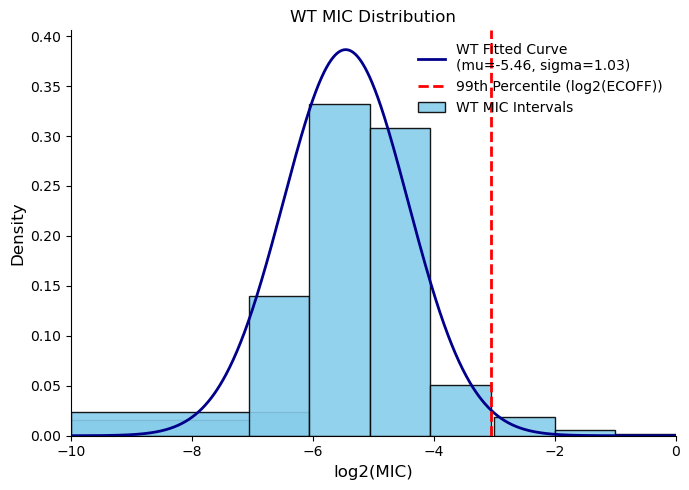

In [36]:
y_low, y_high = init_obj.define_intervals(init_obj.df)
utils.plot_ecoff_distributions(y_low, y_high, mu, sigma_hat, z_99, -10, 0)

# MIC catalogue 

Fit regression lines to each BDQ mutation using meintreg (so I have a reference for when I build catomatic's catalogue builder)

In [156]:
from catomatic.RegressionCatalogue import BuildRegressionCatalogue
import numpy as np


In [157]:
mutations = pd.read_csv('../data/ignore/MUTATIONS_BDQ.csv').reset_index()
genomes = pd.read_csv('../../BDQ_analysis/tb-bdq-cat/data/GENOMES.csv.gz').reset_index()
phenotypes = pd.read_csv('../data/ignore/phenotypes_bdq.csv').reset_index()

phenotypes = phenotypes[~phenotypes.METHOD_MIC.isna()]
phenotypes = phenotypes.groupby("UNIQUEID").apply(filter_multiple_phenos).reset_index(drop=True)

samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])[["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC", "METHOD_2"]].rename(columns={'METHOD_MIC':'MIC'})
samples = samples[samples.METHOD_3.isin(['MGIT960'])]

mutations = mutations[~mutations.GENE.isin(['mmpL5', 'mmpS5'])]

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_73911/2932236636.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotypes = phenotypes.groupby("UNIQUEID").apply(filter_multiple_phenos).reset_index(drop=True)


In [158]:
pd.merge(samples, mutations, how='left', on='UNIQUEID')

,UNIQUEID,DRUG,SOURCE,METHOD_3,PHENOTYPE,MIC,METHOD_2,level_0,Unnamed: 0,index,...,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS
0,site.10.subj.BA00362371.lab.BA00362371.iso.1,BDQ,NICD,MGIT960,R,2,MGIT,2488.0,39508.0,39508.0,...,138.0,True,1.0,g,NaN,NaN,NaN,False,NaN,NaN
1,site.10.subj.BC01130569.lab.BC01130569.iso.1,BDQ,NICD,MGIT960,R,2,MGIT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,site.10.subj.BC01202171.lab.BC01202171.iso.1,BDQ,NICD,MGIT960,S,0.5,MGIT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,site.10.subj.BC01215382.lab.BC01215382.iso.1,BDQ,NICD,MGIT960,S,0.5,MGIT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,site.10.subj.BC01232303.lab.BC01232303.iso.1,BDQ,NICD,MGIT960,S,<=0.125,MGIT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,site.10.subj.YA00194349.lab.YA00194349.iso.1,BDQ,NICD,MGIT960,R,2,MGIT,2396.0,38674.0,38674.0,...,193.0,True,-1.0,g,NaN,NaN,0.0,True,193_del_g,0.537
701,site.10.subj.YA00194374.lab.YA00194374.iso.1,BDQ,NICD,MGIT960,R,2,MGIT,2321.0,38074.0,38074.0,...,141.0,True,1.0,c,NaN,NaN,0.0,True,141_ins_c,0.455
702,site.10.subj.YA00194374.lab.YA00194374.iso.1,BDQ,NICD,MGIT960,R,2,MGIT,2322.0,38075.0,38075.0,...,423.0,True,1.0,c,NaN,NaN,0.0,True,423_ins_c,0.645
703,site.10.subj.YA00205997.lab.YA00205997.iso.1,BDQ,NICD,MGIT960,R,2,MGIT,2830.0,42078.0,42078.0,...,41.0,True,NaN,NaN,41.0,D,1.0,False,NaN,NaN


In [159]:
catalogue, X = BuildRegressionCatalogue(samples, mutations).predict_effects()

In [160]:
catalogue

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 942.9120445381519
        x: [-1.169e-02 -4.356e-01 ...  8.549e-01  1.329e-01]
      nit: 167
      jac: [ 1.364e-04 -2.274e-04 ... -4.547e-05  7.890e-03]
     nfev: 69888
     njev: 192
 hess_inv: <363x363 LbfgsInvHessProduct with dtype=float64>